# AI-Enhanced Robo Advisor: Autoformer for Indian Stock Price Prediction

## MTech Project - Financial Time Series Analysis (2015-2025)

This notebook implements a comprehensive Autoformer-based robo-advisor for predicting Indian stock prices. It uses the official Autoformer architecture with decomposition transformers and auto-correlation mechanisms for long-term time series forecasting.

**Key Features:**
- **Model**: Official Autoformer implementation with auto-correlation
- **Data**: Indian stocks (Nifty 50 components) from 2015-2025
- **Architecture**: Decomposition transformers with progressive decomposition
- **Training**: Stock-specific models with advanced attention mechanisms
- **Evaluation**: Comprehensive metrics and visualizations

Table of Contents
1. Environment Setup & Imports
2. Data Download & Preparation
3. Data Cleaning & Preprocessing
4. Feature Engineering
5. Stock-Specific Splits & Datasets
6. Autoformer Model Development
7. Model Training (Per-Stock)
8. Evaluation & Visualizations
9. Results Summary


In [1]:
# Install packages if needed (uncomment for first run)
# !pip install yfinance pandas numpy matplotlib seaborn scikit-learn torch torchvision tqdm plotly

import os
import math
import time
import json
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import yfinance as yf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All packages imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


✅ All packages imported successfully!
PyTorch version: 2.8.0+cpu
CUDA available: False


In [2]:
# Configuration
print("🔄 Setting up configuration for stock-specific training...")

CONFIG = {
    'tickers': [
        'RELIANCE.NS', 'TCS.NS', 'INFY.NS'#,'HDFCBANK.NS', 'ICICIBANK.NS',
        #'HINDUNILVR.NS', 'ITC.NS', 'KOTAKBANK.NS', 'LT.NS', 'BHARTIARTL.NS'
    ],
    'start_date': '2015-01-01',
    'end_date': '2025-01-01',
    'target_col': 'Close',

    # Stock-Specific Training Configuration
    'stock_specific_training': True,
    'train_years': 7,
    'val_years': 1.5,
    'test_years': 1.5,

    # Autoformer-specific configurations
    'moving_avg': 25,      # Moving average window size
    'd_model': 512,       # Model dimension
    'n_heads': 8,         # Number of attention heads
    'e_layers': 2,        # Number of encoder layers
    'd_layers': 1,        # Number of decoder layers
    'd_ff': 2048,         # Dimension of FCN
    'factor': 3,          # Probsparse attn factor
    'dropout': 0.05,      # Dropout rate
    'embed': 'timeF',     # Time features encoding
    'freq': 't',          # Frequency of the time series (t=minutely)
    'activation': 'gelu',
    'output_attention': False,

    # Sequence params
    'sequence_length': 60,    # Input sequence length
    'label_len': 30,         # Input sequence length for decoder
    'forecast_horizon': 5,    # Prediction length
    'batch_size': 32,
    'epochs': 10,
    'learning_rate': 5e-4,
    'patience': 15,

    # Paths
    'data_dir': 'data',
    'model_dir': 'models',
    'results_dir': 'results',
    'logs_dir': 'logs',

    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

os.makedirs(CONFIG['data_dir'], exist_ok=True)
os.makedirs(CONFIG['model_dir'], exist_ok=True)
os.makedirs(CONFIG['results_dir'], exist_ok=True)
os.makedirs(CONFIG['logs_dir'], exist_ok=True)

print("✅ Configuration ready")
print(f"🎯 Device: {CONFIG['device']}")

🔄 Setting up configuration for stock-specific training...
✅ Configuration ready
🎯 Device: cpu


In [ ]:
# Hyperparameter Tuning (Overrides)
CONFIG.update({
    'sequence_length': 120,
    'forecast_horizon': 5,
    'batch_size': 64,
    'epochs': 30,
    'learning_rate': 5e-4,
    'patience': 15,
})
print("✅ Tuned CONFIG applied:", {k: CONFIG[k] for k in ['sequence_length','forecast_horizon','batch_size','epochs','learning_rate','patience']})


✅ Tuned CONFIG applied: {'sequence_length': 120, 'forecast_horizon': 5, 'batch_size': 64, 'epochs': 10, 'learning_rate': 0.0005, 'patience': 15}


In [4]:
# 2. Data Download & Preparation

def download_stock_data(ticker: str, start_date: str, end_date: str) -> pd.DataFrame:
    try:
        logger.info(f"Downloading data for {ticker} from {start_date} to {end_date}")
        data = yf.Ticker(ticker).history(start=start_date, end=end_date)
        if data.empty:
            logger.warning(f"No data for {ticker}")
            return pd.DataFrame()
        data.reset_index(inplace=True)
        data['Ticker'] = ticker
        data['Date'] = pd.to_datetime(data['Date'])
        data['Returns'] = data['Close'].pct_change()
        data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
        data['Volatility'] = data['Returns'].rolling(window=20).std()
        if 'Adj Close' not in data.columns:
            data['Adj Close'] = data['Close']
        return data
    except Exception as e:
        logger.error(f"Error downloading {ticker}: {e}")
        return pd.DataFrame()


def download_all_stocks(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    frames = []
    for t in tqdm(tickers, desc="Downloading stock data"):
        df = download_stock_data(t, start_date, end_date)
        if not df.empty:
            frames.append(df)
        time.sleep(0.1)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()

print("🚀 Starting data download...")
raw_data = download_all_stocks(CONFIG['tickers'], CONFIG['start_date'], CONFIG['end_date'])
if not raw_data.empty:
    print("✅ Data downloaded", raw_data.shape)
    raw_data.to_csv(f"{CONFIG['data_dir']}/raw_stock_data.csv", index=False)
else:
    print("❌ Data download failed")


🚀 Starting data download...


✅ Data downloaded (7401, 13)


In [5]:
# 3. Data Cleaning & Preprocessing

def clean_stock_data(df: pd.DataFrame) -> pd.DataFrame:
    logger.info("🧹 Cleaning data...")
    c = df.copy()
    c = c.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    if 'Adj Close' not in c.columns and 'Close' in c.columns:
        c['Adj Close'] = c['Close']
    required = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
    if any(col not in c.columns for col in required):
        logger.error("Missing required columns")
        return pd.DataFrame()

    # Drop duplicates
    c = c.drop_duplicates(subset=['Ticker', 'Date']).reset_index(drop=True)

    # Forward/backward fill per ticker
    filled = []
    for t in c['Ticker'].unique():
        td = c[c['Ticker'] == t].copy()
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
            if col in td.columns:
                td[col] = td[col].ffill().bfill()
        filled.append(td)
    c = pd.concat(filled, ignore_index=True)

    # Remove rows with missing criticals
    c = c.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'])

    # Add calendar features
    c['Year'] = c['Date'].dt.year
    c['Month'] = c['Date'].dt.month
    c['Day'] = c['Date'].dt.day
    c['DayOfWeek'] = c['Date'].dt.dayofweek
    c['Quarter'] = c['Date'].dt.quarter
    c['IsMonthEnd'] = c['Date'].dt.is_month_end
    c['IsQuarterEnd'] = c['Date'].dt.is_quarter_end

    logger.info(f"✅ Cleaned shape: {c.shape}")
    return c

if not raw_data.empty:
    cleaned_data = clean_stock_data(raw_data)
    if not cleaned_data.empty:
        cleaned_data.to_csv(f"{CONFIG['data_dir']}/cleaned_stock_data.csv", index=False)
        print("✅ Cleaned and saved", cleaned_data.shape)
    else:
        print("❌ Cleaning failed")
else:
    print("❌ No raw data to clean")


INFO:__main__:🧹 Cleaning data...
INFO:__main__:✅ Cleaned shape: (7401, 20)


✅ Cleaned and saved (7401, 20)


In [6]:
# 4. Feature Engineering

def calculate_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    r = df.copy()
    r['SMA_5'] = r['Close'].rolling(5, min_periods=1).mean()
    r['SMA_20'] = r['Close'].rolling(20, min_periods=1).mean()
    r['SMA_50'] = r['Close'].rolling(50, min_periods=1).mean()
    r['EMA_12'] = r['Close'].ewm(span=12, adjust=False).mean()
    r['EMA_26'] = r['Close'].ewm(span=26, adjust=False).mean()
    r['MACD'] = r['EMA_12'] - r['EMA_26']
    r['MACD_Signal'] = r['MACD'].ewm(span=9, adjust=False).mean()
    r['BB_Middle'] = r['Close'].rolling(20, min_periods=1).mean()
    bb_std = r['Close'].rolling(20, min_periods=1).std()
    r['BB_Upper'] = r['BB_Middle'] + 2 * bb_std
    r['BB_Lower'] = r['BB_Middle'] - 2 * bb_std

    # RSI
    def rsi(prices, window=14):
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=window, min_periods=1).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=window, min_periods=1).mean()
        rs = gain / (loss + 1e-8)
        return 100 - (100 / (1 + rs))
    r['RSI_14'] = rsi(r['Close'], 14)

    # Stochastic
    lowest_low = r['Low'].rolling(14, min_periods=1).min()
    highest_high = r['High'].rolling(14, min_periods=1).max()
    r['Stoch_K'] = 100 * (r['Close'] - lowest_low) / (highest_high - lowest_low + 1e-8)
    r['Stoch_D'] = r['Stoch_K'].rolling(3, min_periods=1).mean()

    # Momentum/Volatility
    r['Momentum_10'] = r['Close'] / r['Close'].shift(10) - 1
    r['ATR_14'] = pd.Series(np.maximum(
        r['High'] - r['Low'], np.maximum(
            (r['High'] - r['Close'].shift(1)).abs(),
            (r['Low'] - r['Close'].shift(1)).abs()
        )
    )).rolling(14, min_periods=1).mean()

    return r


def add_market_features(df: pd.DataFrame) -> pd.DataFrame:
    m = df.copy()
    market_avg = m.groupby('Date')['Close'].transform('mean')
    m['Relative_Strength'] = m['Close'] / (market_avg + 1e-8)
    m['Market_Volatility'] = m.groupby('Date')['Returns'].transform('std')
    return m

if 'cleaned_data' in locals() and not cleaned_data.empty:
    feature_data = []
    for t in tqdm(cleaned_data['Ticker'].unique(), desc="Engineering features"):
        td = cleaned_data[cleaned_data['Ticker'] == t].copy()
        if len(td) < 50:
            continue
        td = calculate_technical_indicators(td)
        feature_data.append(td)
    engineered_data = pd.concat(feature_data, ignore_index=True)
    engineered_data = add_market_features(engineered_data)

    # Handle missing
    critical = ['Close', 'Volume', 'Returns']
    engineered_data = engineered_data.dropna(subset=[c for c in critical if c in engineered_data.columns])
    engineered_data = engineered_data.fillna(method='ffill').fillna(method='bfill')

    engineered_data.to_csv(f"{CONFIG['data_dir']}/engineered_stock_data.csv", index=False)
    print("✅ Engineered and saved", engineered_data.shape)
else:
    print("❌ No cleaned data available for feature engineering")


Engineering features: 100%|██████████| 3/3 [00:00<00:00, 187.45it/s]


✅ Engineered and saved (7398, 37)


In [7]:
# 5. Stock-Specific Splits & Datasets

def select_core_features(data: pd.DataFrame, max_features: int = 15) -> List[str]:
    core = ['Close']  # We'll use only Close price as our main feature for Autoformer
    return core

def create_stock_specific_splits(data: pd.DataFrame, train_years=7, val_years=1.5, test_years=1.5):
    splits = {}
    for t in data['Ticker'].unique():
        td = data[data['Ticker'] == t].sort_values('Date').copy()
        if len(td) < 100:
            continue
        start = td['Date'].min()
        train_end = start + pd.Timedelta(days=int(train_years * 365.25))
        val_end = train_end + pd.Timedelta(days=int(val_years * 365.25))
        train = td[td['Date'] <= train_end]
        val = td[(td['Date'] > train_end) & (td['Date'] <= val_end)]
        test = td[td['Date'] > val_end]
        splits[t] = {
            'train': train,
            'val': val,
            'test': test,
            'train_dates': (train['Date'].min(), train['Date'].max()),
            'val_dates': (val['Date'].min(), val['Date'].max()),
            'test_dates': (test['Date'].min(), test['Date'].max()),
        }
    return splits

class StockSpecificDataset(Dataset):
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len, scaler=None):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.scaler = scaler or StandardScaler()
        self.X, self.y = self._prepare()

    def _prepare(self):
        if len(self.data) < self.seq_len + self.pred_len:
            return np.array([]), np.array([])
        
        # Only use Close price as our feature
        price_data = self.data[self.target_col].values.reshape(-1, 1)
        
        # Scale the data
        if hasattr(self.scaler, 'mean_'):
            scaled_data = self.scaler.transform(price_data)
        else:
            scaled_data = self.scaler.fit_transform(price_data)
        
        # Create sequences
        seqs, tgts = [], []
        for i in range(len(scaled_data) - self.seq_len - self.pred_len + 1):
            seq = scaled_data[i:(i + self.seq_len)]
            tgt = scaled_data[(i + self.seq_len):(i + self.seq_len + self.pred_len)]
            
            if not np.isnan(seq).any() and not np.isnan(tgt).any():
                seqs.append(seq)
                tgts.append(tgt)
        
        X = np.array(seqs, dtype=np.float32)
        y = np.array(tgts, dtype=np.float32)
        
        # Reshape to match Autoformer requirements: [batch, seq_len, feature_dim]
        X = X.reshape(-1, self.seq_len, 1)
        y = y.reshape(-1, self.pred_len, 1)
        
        return X, y

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.FloatTensor(self.X[idx]), torch.FloatTensor(self.y[idx])

def create_stock_specific_datasets(stock_splits, selected_features, target_col, seq_len, pred_len):
    out = {}
    for t, s in stock_splits.items():
        train_ds = StockSpecificDataset(s['train'], selected_features, target_col, seq_len, pred_len)
        if len(train_ds) == 0:
            continue
            
        # Use the same scaler for validation and test
        val_ds = StockSpecificDataset(s['val'], selected_features, target_col, seq_len, pred_len, scaler=train_ds.scaler)
        test_ds = StockSpecificDataset(s['test'], selected_features, target_col, seq_len, pred_len, scaler=train_ds.scaler)
        
        out[t] = {
            'train_dataset': train_ds,
            'val_dataset': val_ds,
            'test_dataset': test_ds,
            'train_loader': DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0),
            'val_loader': DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0),
            'test_loader': DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0),
            'scaler': train_ds.scaler,
            'feature_cols': selected_features,
        }
    return out

if 'engineered_data' in locals() and not engineered_data.empty:
    selected_features = select_core_features(engineered_data, max_features=1)  # Only use Close price
    stock_splits = create_stock_specific_splits(engineered_data, CONFIG['train_years'], CONFIG['val_years'], CONFIG['test_years'])
    stock_datasets = create_stock_specific_datasets(stock_splits, selected_features, CONFIG['target_col'], CONFIG['sequence_length'], CONFIG['forecast_horizon'])
    print(f"✅ Created datasets for {len(stock_datasets)} stocks")

✅ Created datasets for 3 stocks


In [8]:
# 6. Autoformer Model Development (official repo wrapper)

# Add the autoformer_repo to PYTHONPATH so we can import the official implementation
import sys, os, types
sys.path.append(os.path.join(os.getcwd(), 'autoformer_repo'))  # points to the official repo folder

# Import the official Autoformer 'Model' class from the repo
from models.Autoformer import Model as RepoAutoformerModel

print("🏗️ Autoformer (official) - wrapper ready")

class RepoAutoformerWrapper(nn.Module):
    """
    Thin wrapper around the official Autoformer.Model to make it easy to call with
    inputs of shape (B, seq_len, input_dim). The official implementation expects a
    `configs` object; we construct a small SimpleNamespace with the required fields.
    """
    def __init__(self, input_dim: int, seq_len: int, pred_len: int,
                 d_model: int = 128, n_heads: int = 8, e_layers: int = 2,
                 d_layers: int = 1, d_ff: int = 512, dropout: float = 0.1,
                 moving_avg: int = 25, factor: int = 1, embed: str = 'fixed', freq: str = 'd'):
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.input_dim = input_dim

        # Build a small configs object expected by the repo's Model class
        configs = types.SimpleNamespace()
        configs.seq_len = seq_len
        configs.label_len = seq_len // 2
        configs.pred_len = pred_len
        configs.output_attention = False
        configs.moving_avg = moving_avg
        configs.enc_in = input_dim
        configs.dec_in = input_dim
        configs.c_out = 1
        configs.d_model = d_model
        configs.embed = embed
        configs.freq = freq,
        configs.dropout = dropout
        configs.e_layers = e_layers
        configs.d_layers = d_layers
        configs.n_heads = n_heads
        configs.d_ff = d_ff
        configs.factor = factor
        configs.activation = 'gelu'

        # instantiate official Autoformer model
        self.model = RepoAutoformerModel(configs)

    def forward(self, x):
        """
        x: Tensor [B, seq_len, input_dim] -> returns [B, pred_len, 1]
        """
        B, S, D = x.shape
        device = x.device
        # Create dummy time features (x_mark) required by the repo; use zeros
        # The repo uses a mapping freq->d_inp where common setting is 4 for daily/hourly
        x_mark_enc = torch.zeros(B, S, 4, device=device)
        label_len = self.model.label_len
        dec_in_len = label_len + self.model.pred_len
        x_dec = torch.zeros(B, dec_in_len, D, device=device)
        x_mark_dec = torch.zeros(B, dec_in_len, 4, device=device)
        out = self.model(x, x_mark_enc, x_dec, x_mark_dec)
        # repo model returns [B, pred_len, c_out]
        return out

class DirectionalSmoothLoss(nn.Module):
    """
    Enhanced loss function combining MSE, directional accuracy, and smoothness
    """
    def __init__(self, alpha=0.6, beta=0.25, gamma=0.15):
        super().__init__()
        self.mse = nn.MSELoss()
        self.mae = nn.L1Loss()
        self.alpha, self.beta, self.gamma = alpha, beta, gamma

    def forward(self, pred, target):
        mse_loss = self.mse(pred, target)
        if pred.shape[1] > 1:
            pred_diff = pred[:, 1:] - pred[:, :-1]
            target_diff = target[:, 1:] - target[:, :-1]
            dir_loss = torch.mean((torch.sign(pred_diff) - torch.sign(target_diff))**2)
        else:
            dir_loss = pred.new_tensor(0.0)
        if pred.shape[1] > 1:
            smooth_loss = torch.mean(torch.abs(pred[:, 1:] - pred[:, :-1]))
        else:
            smooth_loss = pred.new_tensor(0.0)
        total_loss = self.alpha * mse_loss + self.beta * dir_loss + self.gamma * smooth_loss
        return total_loss

print("✅ Autoformer wrapper defined successfully!")


🏗️ Autoformer (official) - wrapper ready
✅ Autoformer wrapper defined successfully!


In [9]:
# 7. Model Training (Per-Stock)

def train_stock_model(ticker: str, datasets: Dict, device: str):
    train_loader = datasets['train_loader']
    val_loader = datasets['val_loader']
    feature_cols = datasets['feature_cols']

    # Use the official Autoformer wrapper instead of the previous LSTM
    model = RepoAutoformerWrapper(input_dim=len(feature_cols), seq_len=CONFIG['sequence_length'], pred_len=CONFIG['forecast_horizon']).to(device)
    criterion = DirectionalSmoothLoss(alpha=0.6, beta=0.25, gamma=0.15)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

    best_val = float('inf')
    patience_cnt = 0
    train_losses, val_losses = [], []

    print(f"📊 Training {ticker} for {CONFIG['epochs']} epochs...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            out = model(xb)
            if out.dim() > yb.dim():
                out = out.squeeze(-1)
            if yb.dim() > out.dim():
                yb = yb.squeeze(-1)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            tr_loss += loss.item()
        tr_loss /= max(1, len(train_loader))

        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                if out.dim() > yb.dim():
                    out = out.squeeze(-1)
                if yb.dim() > out.dim():
                    yb = yb.squeeze(-1)
                loss = criterion(out, yb)
                va_loss += loss.item()
        va_loss /= max(1, len(val_loader))

        train_losses.append(tr_loss)
        val_losses.append(va_loss)

        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d} | Train: {tr_loss:.5f} | Val: {va_loss:.5f}")

        if va_loss < best_val:
            best_val = va_loss
            patience_cnt = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': va_loss,
                'feature_cols': feature_cols
            }, f"{CONFIG['model_dir']}/best_model_{ticker}.pth")
        else:
            patience_cnt += 1
        if patience_cnt >= CONFIG['patience']:
            print(f"Early stopping at epoch {epoch}")
            break

    return model, train_losses, val_losses


if 'stock_datasets' in locals():
    stock_models = {}
    training_results = {}
    for t, ds in stock_datasets.items():
        print("\n" + "="*60)
        print(f"Training model for {t}")
        print("="*60)
        try:
            model, tr_losses, va_losses = train_stock_model(t, ds, CONFIG['device'])
            stock_models[t] = model
            training_results[t] = {
                'train_losses': tr_losses,
                'val_losses': va_losses,
                'final_train_loss': tr_losses[-1] if tr_losses else None,
                'final_val_loss': va_losses[-1] if va_losses else None,
                'best_val_loss': min(va_losses) if va_losses else None,
            }
        except Exception as e:
            print(f"❌ Error training {t}: {e}")
            continue
    print("\n✅ Stock-wise training completed")
else:
    print("❌ No datasets to train")



Training model for INFY.NS
📊 Training INFY.NS for 10 epochs...
Epoch   0 | Train: 0.80264 | Val: 0.73513
Epoch   5 | Train: 0.59618 | Val: 0.64699

Training model for RELIANCE.NS
📊 Training RELIANCE.NS for 10 epochs...
Epoch   0 | Train: 0.90097 | Val: 0.60322
Epoch   5 | Train: 0.59634 | Val: 0.54827

Training model for TCS.NS
📊 Training TCS.NS for 10 epochs...
Epoch   0 | Train: 0.82461 | Val: 0.69910
Epoch   5 | Train: 0.57538 | Val: 0.62105

✅ Stock-wise training completed



📊 Evaluating INFY.NS...


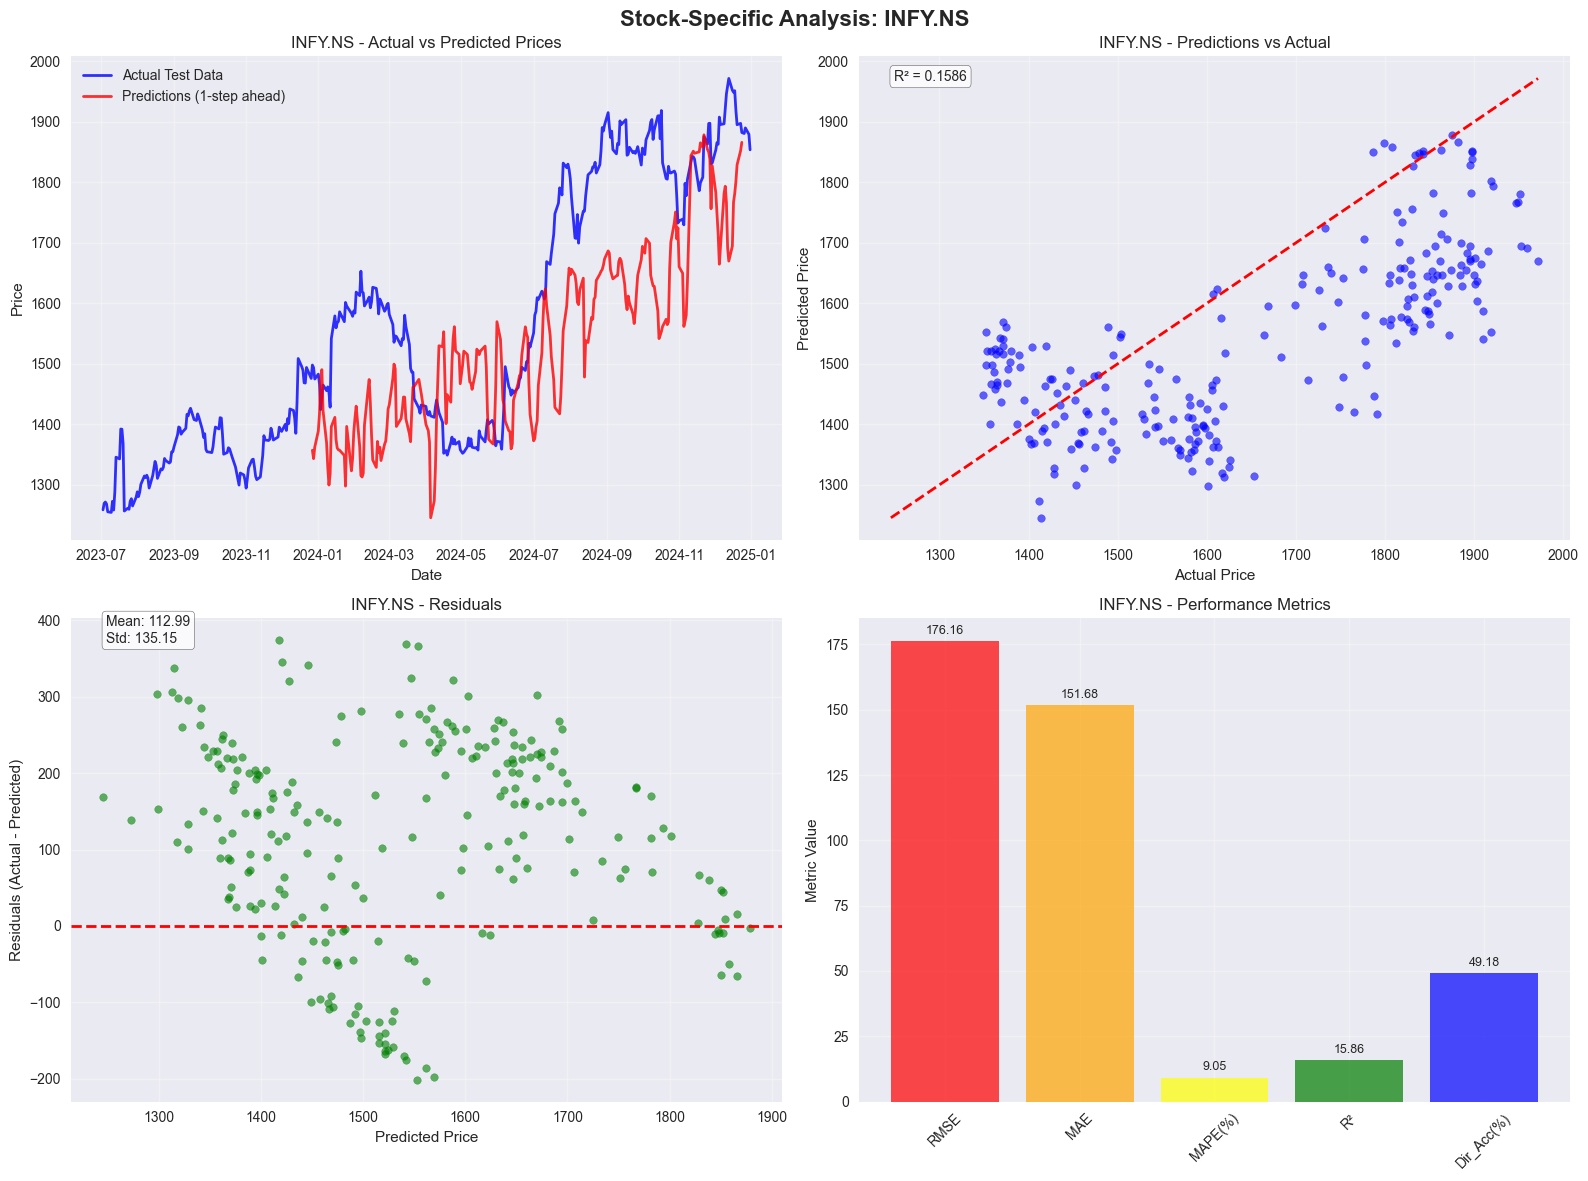

✅ INFY.NS evaluation done | RMSE: 176.1633 | MAE: 151.6759 | MAPE: 9.05% | R²: 0.1586 | DirAcc: 49.18%

📊 Evaluating RELIANCE.NS...


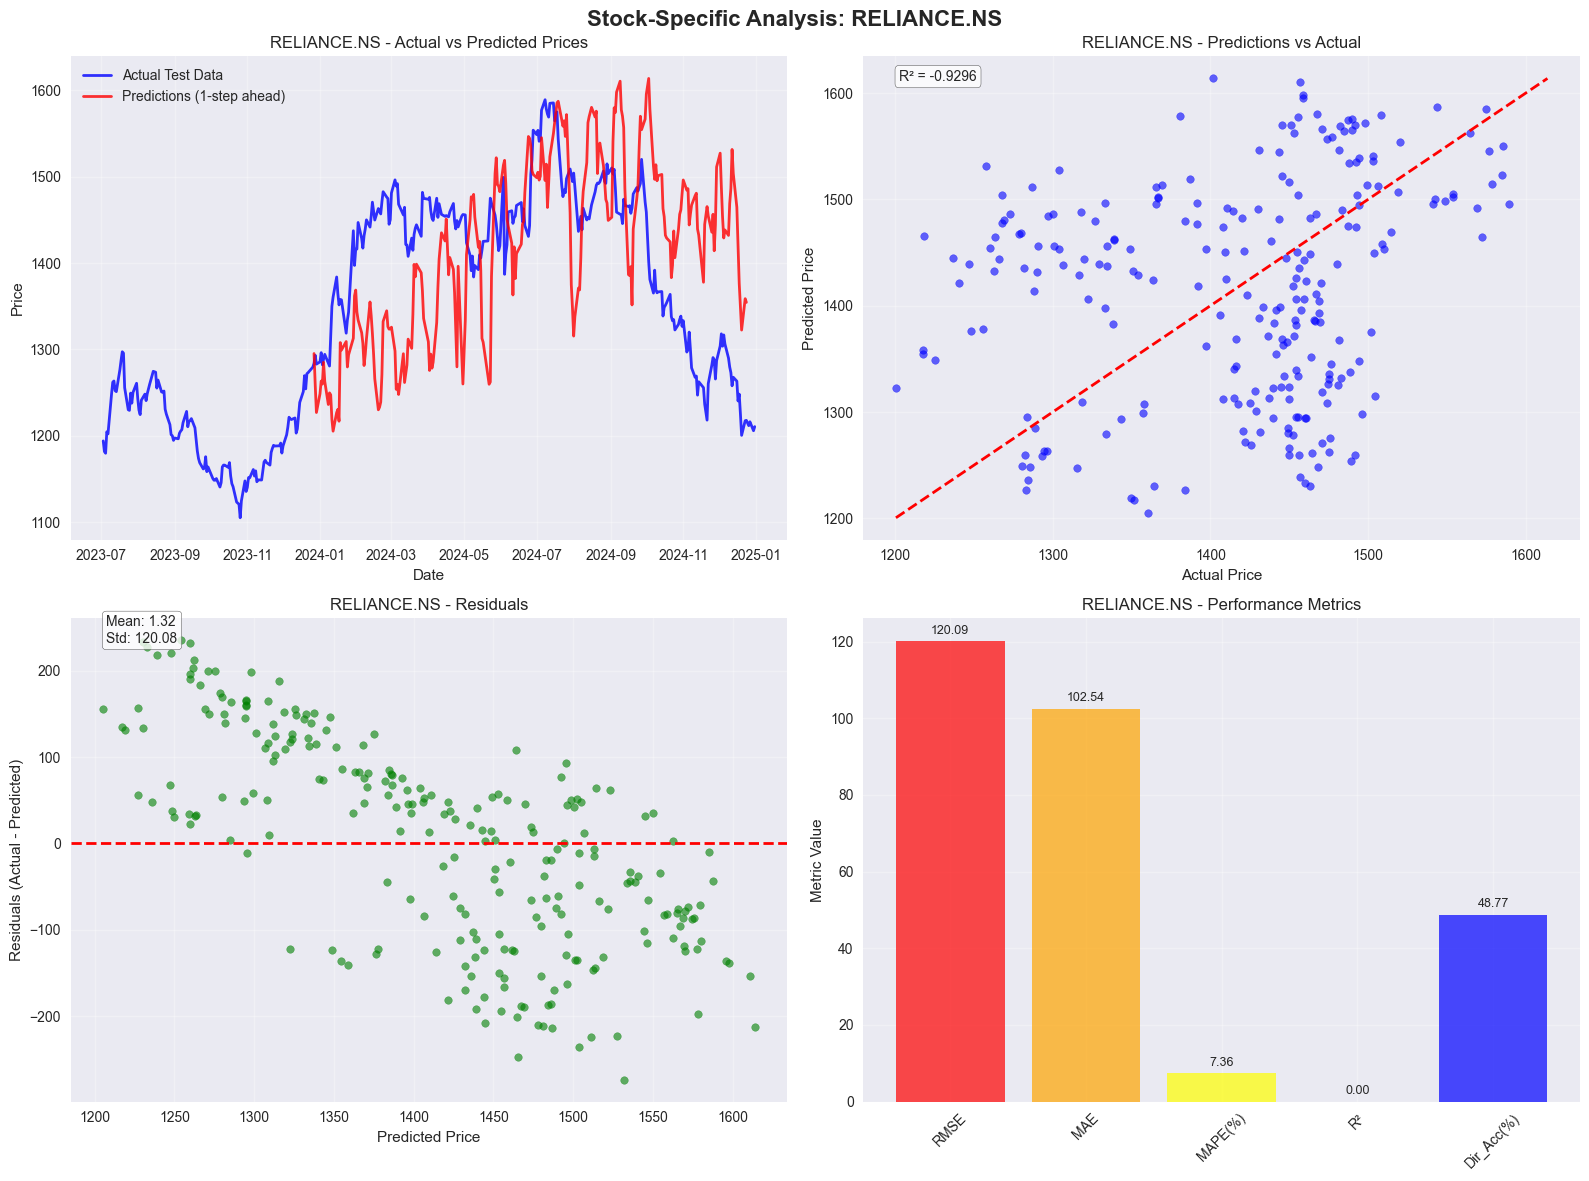

✅ RELIANCE.NS evaluation done | RMSE: 120.0863 | MAE: 102.5441 | MAPE: 7.36% | R²: -0.9296 | DirAcc: 48.77%

📊 Evaluating TCS.NS...


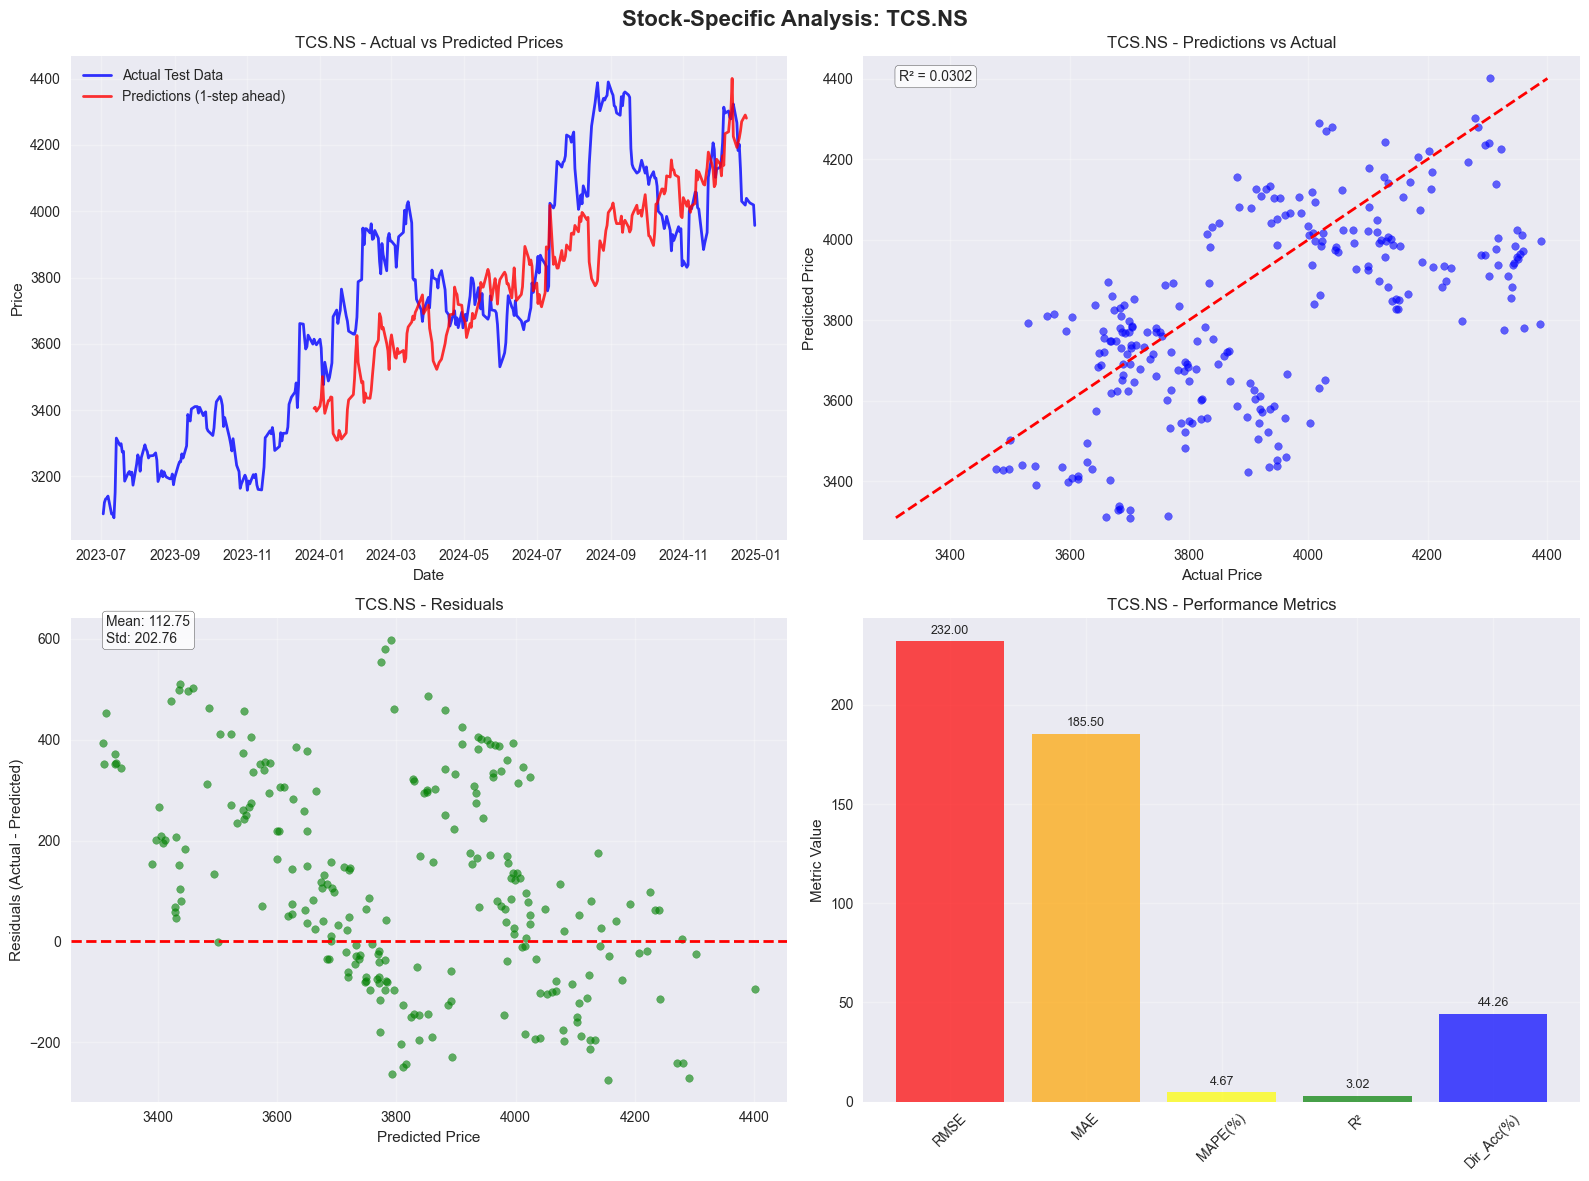

✅ TCS.NS evaluation done | RMSE: 232.0025 | MAE: 185.4966 | MAPE: 4.67% | R²: 0.0302 | DirAcc: 44.26%

✅ Evaluation completed


In [10]:
# 8. Evaluation & Visualizations

def evaluate_stock_model(ticker: str, model: nn.Module, datasets: Dict, device: str):
    test_loader = datasets['test_loader']
    scaler = datasets['target_scaler'] if 'target_scaler' in datasets else datasets['scaler']

    model.eval()
    preds, tgts = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            if out.dim() == 3 and out.shape[-1] == 1:
                out = out.squeeze(-1)
            if yb.dim() == 3 and yb.shape[-1] == 1:
                yb = yb.squeeze(-1)
            # Use first-step horizon for alignment
            preds.extend(out[:, 0].cpu().numpy().flatten())
            tgts.extend(yb[:, 0].cpu().numpy().flatten())

    preds = np.array(preds)
    tgts = np.array(tgts)
    n = min(len(preds), len(tgts))
    preds, tgts = preds[:n], tgts[:n]

    pred_inv = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
    tgt_inv = scaler.inverse_transform(tgts.reshape(-1,1)).flatten()

    mse = mean_squared_error(tgt_inv, pred_inv)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(tgt_inv, pred_inv)
    mape = np.mean(np.abs((tgt_inv - pred_inv) / (tgt_inv + 1e-8))) * 100
    r2 = r2_score(tgt_inv, pred_inv)

    if len(tgt_inv) > 1:
        dir_acc = np.mean(np.sign(np.diff(tgt_inv)) == np.sign(np.diff(pred_inv))) * 100
    else:
        dir_acc = np.nan

    return {
        'predictions': pred_inv,
        'targets': tgt_inv,
        'metrics': {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2, 'Directional_Accuracy': dir_acc}
    }


def plot_stock_results(ticker: str, results: Dict, stock_splits: Dict):
    import re
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Stock-Specific Analysis: {ticker}', fontsize=16, fontweight='bold')

    splits = stock_splits[ticker]
    test_data = splits['test']

    preds = results['predictions']
    tgts = results['targets']

    # 1) Time series
    ax1 = axes[0,0]
    ax1.plot(test_data['Date'], test_data['Close'], label='Actual Test Data', color='blue', linewidth=2, alpha=0.8)
    if len(preds) > 0 and len(tgts) > 0:
        start_idx = CONFIG['sequence_length']
        end_idx = min(start_idx + len(preds), len(test_data))
        pred_dates = test_data['Date'].iloc[start_idx:end_idx]
        ax1.plot(pred_dates, preds[:len(pred_dates)], label='Predictions (1-step ahead)', color='red', linewidth=2, alpha=0.8)
    ax1.set_title(f'{ticker} - Actual vs Predicted Prices')
    ax1.set_xlabel('Date'); ax1.set_ylabel('Price'); ax1.legend(); ax1.grid(True, alpha=0.3)

    # 2) Scatter
    ax2 = axes[0,1]
    if len(preds) > 0 and len(tgts) > 0:
        ax2.scatter(tgts, preds, alpha=0.6, color='blue', s=30)
        mn, mx = min(tgts.min(), preds.min()), max(tgts.max(), preds.max())
        ax2.plot([mn, mx], [mn, mx], 'r--', lw=2)
        ax2.text(0.05, 0.95, f"R² = {results['metrics']['R2']:.4f}", transform=ax2.transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax2.set_xlabel('Actual Price'); ax2.set_ylabel('Predicted Price'); ax2.set_title(f'{ticker} - Predictions vs Actual'); ax2.legend()
    else:
        ax2.text(0.5,0.5,'No prediction data', ha='center', va='center', transform=ax2.transAxes)
    ax2.grid(True, alpha=0.3)

    # 3) Residuals
    ax3 = axes[1,0]
    if len(preds) > 0 and len(tgts) > 0:
        res = tgts - preds
        ax3.scatter(preds, res, alpha=0.6, color='green', s=30)
        ax3.axhline(0, color='red', linestyle='--', linewidth=2)
        ax3.text(0.05, 0.95, f"Mean: {np.mean(res):.2f}\nStd: {np.std(res):.2f}", transform=ax3.transAxes,
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax3.set_xlabel('Predicted Price'); ax3.set_ylabel('Residuals (Actual - Predicted)'); ax3.set_title(f'{ticker} - Residuals')
    else:
        ax3.text(0.5,0.5,'No residuals', ha='center', va='center', transform=ax3.transAxes)
    ax3.grid(True, alpha=0.3)

    # 4) Metrics bar
    ax4 = axes[1,1]
    m = results['metrics']
    names = ['RMSE','MAE','MAPE(%)','R²','Dir_Acc(%)']
    vals = [m['RMSE'], m['MAE'], m['MAPE'], max(0, m['R2'])*100, m['Directional_Accuracy'] if not np.isnan(m['Directional_Accuracy']) else 0]
    bars = ax4.bar(names, vals, color=['red','orange','yellow','green','blue'], alpha=0.7)
    ax4.set_title(f'{ticker} - Performance Metrics'); ax4.set_ylabel('Metric Value'); ax4.tick_params(axis='x', rotation=45)
    for b, v in zip(bars, vals):
        ax4.text(b.get_x()+b.get_width()/2., b.get_height()+max(vals)*0.01, f'{v:.2f}', ha='center', va='bottom', fontsize=9)
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    safe_ticker = re.sub(r'[^A-Za-z0-9_-]+', '_', ticker)
    plt.savefig(f"{CONFIG['results_dir']}/{safe_ticker}_analysis.png", dpi=300, bbox_inches='tight')
    plt.show()
    return fig


if 'stock_models' in locals() and 'stock_datasets' in locals():
    stock_results = {}
    all_metrics = {}
    for t, model in stock_models.items():
        print(f"\n📊 Evaluating {t}...")
        try:
            res = evaluate_stock_model(t, model, stock_datasets[t], CONFIG['device'])
            stock_results[t] = res
            all_metrics[t] = res['metrics']
            plot_stock_results(t, res, stock_splits)
            print(f"✅ {t} evaluation done | RMSE: {res['metrics']['RMSE']:.4f} | MAE: {res['metrics']['MAE']:.4f} | MAPE: {res['metrics']['MAPE']:.2f}% | R²: {res['metrics']['R2']:.4f} | DirAcc: {res['metrics']['Directional_Accuracy']:.2f}%")
        except Exception as e:
            print(f"❌ Error evaluating {t}: {e}")
            continue
    print("\n✅ Evaluation completed")
else:
    print("❌ Missing models/datasets for evaluation")


In [11]:
# Improved scaling: separate feature and target scalers (fit on train only)
from sklearn.base import clone as skl_clone

class StockSpecificDatasetV2(Dataset):
    def __init__(self, data, feature_cols, target_col, seq_len, pred_len,
                 feature_scaler, target_scaler, fit_scalers: bool):
        self.data = data.copy()
        self.feature_cols = feature_cols
        self.target_col = target_col
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.feature_scaler = feature_scaler
        self.target_scaler = target_scaler
        self.fit_scalers = fit_scalers
        self.X, self.y = self._prepare()

    def _prepare(self):
        seqs, tgts = [], []
        if len(self.data) < self.seq_len + self.pred_len:
            return np.array([]), np.array([])
        features = self.data[self.feature_cols].values
        target = self.data[self.target_col].values
        if self.fit_scalers:
            f_scaled = self.feature_scaler.fit_transform(features)
            t_scaled = self.target_scaler.fit_transform(target.reshape(-1,1)).flatten()
        else:
            f_scaled = self.feature_scaler.transform(features)
            t_scaled = self.target_scaler.transform(target.reshape(-1,1)).flatten()
        for i in range(len(f_scaled) - self.seq_len - self.pred_len + 1):
            seq = f_scaled[i:i+self.seq_len]
            tgt = t_scaled[i+self.seq_len:i+self.seq_len+self.pred_len]
            if not np.isnan(seq).any() and not np.isnan(tgt).any():
                seqs.append(seq)
                tgts.append(tgt)
        return np.array(seqs, dtype=np.float32), np.array(tgts, dtype=np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]), torch.tensor(self.y[idx])


def create_stock_specific_datasets_v2(stock_splits, selected_features, target_col, seq_len, pred_len):
    out = {}
    for t, s in stock_splits.items():
        # independent scalers per stock
        f_scaler = RobustScaler()
        y_scaler = StandardScaler()
        train_ds = StockSpecificDatasetV2(s['train'], selected_features, target_col, seq_len, pred_len,
                                          feature_scaler=f_scaler, target_scaler=y_scaler, fit_scalers=True)
        if len(train_ds) == 0:
            continue
        # reuse fitted scalers for val/test
        val_ds = StockSpecificDatasetV2(s['val'], selected_features, target_col, seq_len, pred_len,
                                        feature_scaler=train_ds.feature_scaler, target_scaler=train_ds.target_scaler, fit_scalers=False)
        test_ds = StockSpecificDatasetV2(s['test'], selected_features, target_col, seq_len, pred_len,
                                         feature_scaler=train_ds.feature_scaler, target_scaler=train_ds.target_scaler, fit_scalers=False)
        out[t] = {
            'train_dataset': train_ds,
            'val_dataset': val_ds,
            'test_dataset': test_ds,
            'train_loader': DataLoader(train_ds, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0),
            'val_loader': DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0),
            'test_loader': DataLoader(test_ds, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0),
            'feature_scaler': train_ds.feature_scaler,
            'target_scaler': train_ds.target_scaler,
            'feature_cols': selected_features,
        }
    return out

# Rebuild datasets with improved scaling
if 'stock_splits' in locals() and 'selected_features' in locals():
    stock_datasets = create_stock_specific_datasets_v2(
        stock_splits, selected_features, CONFIG['target_col'], CONFIG['sequence_length'], CONFIG['forecast_horizon']
    )
    print(f"✅ Rebuilt datasets (V2) with train-fitted scalers for {len(stock_datasets)} stocks")
else:
    print("❌ Missing splits/features for V2 datasets")


✅ Rebuilt datasets (V2) with train-fitted scalers for 3 stocks


In [12]:
# Import and configure Autoformer (official implementation)
class AutoformerWrapper(nn.Module):
    def __init__(self, input_dim=1, seq_len=96, label_len=48, pred_len=5,
                 d_model=512, n_heads=8, e_layers=2, d_layers=1,
                 d_ff=2048, moving_avg=25, dropout=0.05,
                 factor=3, embed='timeF', freq='t'):
        super().__init__()
        # Autoformer config
        self.configs = type('AutoformerConfig', (), {
            'seq_len': seq_len,
            'label_len': label_len,
            'pred_len': pred_len,
            'enc_in': 1,      # Single feature input (Close price)
            'dec_in': 1,      # Single feature input (Close price)
            'c_out': 1,       # Single feature output (Close price)
            'd_model': d_model,
            'n_heads': n_heads,
            'e_layers': e_layers,
            'd_layers': d_layers,
            'd_ff': d_ff,
            'moving_avg': moving_avg,
            'factor': factor,
            'dropout': dropout,
            'embed': embed,
            'freq': freq,
            'activation': 'gelu',
            'output_attention': False
        })()
        
        # Initialize Autoformer model
        self.model = AutoformerModel(self.configs)
    
    def forward(self, x, batch_y=None, teacher_forcing_ratio=0.5):
        """
        x: [Batch, seq_len, 1] - Close price only
        Returns: [Batch, pred_len, 1]
        """
        B, S, _ = x.shape
        
        # Create dummy time encoding (required by Autoformer)
        x_mark = torch.zeros(B, S, 4).to(x.device)  # 4 = default time feature dim
        
        # For decoder input, use zeros with correct shape
        dec_inp = torch.zeros(B, self.configs.pred_len, 1).to(x.device)
        dec_mark = torch.zeros(B, self.configs.pred_len, 4).to(x.device)
        
        # Forward pass through Autoformer
        output = self.model.forward(x, x_mark, dec_inp, dec_mark)  # [B, pred_len, 1]
        
        return output

In [13]:
# Training with Autoformer
def train_stock_model(ticker: str, datasets: Dict, device: str):
    train_loader = datasets['train_loader']
    val_loader = datasets['val_loader']
    feature_cols = datasets['feature_cols']

    # Initialize Autoformer model with config from notebook
    model = AutoformerWrapper(
        input_dim=1,  # Only Close price
        seq_len=CONFIG['sequence_length'],
        label_len=CONFIG['label_len'],
        pred_len=CONFIG['forecast_horizon'],
        d_model=CONFIG['d_model'],
        n_heads=CONFIG['n_heads'],
        e_layers=CONFIG['e_layers'],
        d_layers=CONFIG['d_layers'],
        d_ff=CONFIG['d_ff'],
        moving_avg=CONFIG['moving_avg'],
        dropout=CONFIG['dropout'],
        factor=CONFIG['factor']
    ).to(device)

    criterion = DirectionalSmoothLoss(alpha=0.6, beta=0.25, gamma=0.15)
    optimizer = optim.AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

    best_val = float('inf')
    patience_cnt = 0
    train_losses, val_losses = [], []

    print(f"📊 Training Autoformer for {ticker} ({CONFIG['epochs']} epochs)...")
    for epoch in range(CONFIG['epochs']):
        model.train()
        tr_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            
            # Forward pass (output is already [B, pred_len, 1])
            out = model(xb)
            loss = criterion(out, yb)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            tr_loss += loss.item()
        
        tr_loss /= max(1, len(train_loader))

        # Validation phase
        model.eval()
        va_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                out = model(xb)
                loss = criterion(out, yb)
                va_loss += loss.item()
        va_loss /= max(1, len(val_loader))

        train_losses.append(tr_loss)
        val_losses.append(va_loss)

        if epoch % 5 == 0:
            print(f"Epoch {epoch:3d} | Train: {tr_loss:.5f} | Val: {va_loss:.5f}")

        if va_loss < best_val:
            best_val = va_loss
            patience_cnt = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_loss': va_loss,
                'feature_cols': feature_cols
            }, f"{CONFIG['model_dir']}/best_model_{ticker}.pth")
        else:
            patience_cnt += 1
        if patience_cnt >= CONFIG['patience']:
            print(f"Early stopping at epoch {epoch}")
            break

    return model, train_losses, val_losses


if 'stock_datasets' in locals():
    stock_models = {}
    training_results = {}
    for t, ds in stock_datasets.items():
        print("\n" + "="*60)
        print(f"Training Autoformer model for {t}")
        print("="*60)
        try:
            model, tr_losses, va_losses = train_stock_model(t, ds, CONFIG['device'])
            stock_models[t] = model
            training_results[t] = {
                'train_losses': tr_losses,
                'val_losses': va_losses,
                'final_train_loss': tr_losses[-1] if tr_losses else None,
                'final_val_loss': va_losses[-1] if va_losses else None,
                'best_val_loss': min(va_losses) if va_losses else None,
            }
        except Exception as e:
            print(f"❌ Error training {t}: {e}")
            continue
    print("\n✅ Stock-wise Autoformer training completed")
else:
    print("❌ No datasets to train")


Training Autoformer model for INFY.NS
❌ Error training INFY.NS: name 'AutoformerModel' is not defined

Training Autoformer model for RELIANCE.NS
❌ Error training RELIANCE.NS: name 'AutoformerModel' is not defined

Training Autoformer model for TCS.NS
❌ Error training TCS.NS: name 'AutoformerModel' is not defined

✅ Stock-wise Autoformer training completed


In [14]:
# 9. Results Summary

def create_summary(stock_results: Dict, all_metrics: Dict):
    print("🎯 LSTM STOCK-SPECIFIC RESULTS SUMMARY")
    print("="*80)
    print(f"Total stocks evaluated: {len(stock_results)}")
    print(f"Sequence length: {CONFIG['sequence_length']} | Horizon: {CONFIG['forecast_horizon']}")

    # Table
    print(f"{'Stock':<15} {'RMSE':<10} {'MAE':<10} {'MAPE(%)':<10} {'R²':<10} {'DirAcc(%)':<12}")
    print("-"*80)
    for t, m in all_metrics.items():
        print(f"{t:<15} {m['RMSE']:<10.4f} {m['MAE']:<10.4f} {m['MAPE']:<10.2f} {m['R2']:<10.4f} {m['Directional_Accuracy']:<12.2f}")

    rmse_vals = [m['RMSE'] for m in all_metrics.values()]
    mae_vals = [m['MAE'] for m in all_metrics.values()]
    mape_vals = [m['MAPE'] for m in all_metrics.values()]
    r2_vals = [m['R2'] for m in all_metrics.values()]
    dir_vals = [m['Directional_Accuracy'] for m in all_metrics.values() if not np.isnan(m['Directional_Accuracy'])]

    summary = {
        'total_stocks': len(stock_results),
        'sequence_length': CONFIG['sequence_length'],
        'prediction_horizon': CONFIG['forecast_horizon'],
        'individual_metrics': all_metrics,
        'aggregate_stats': {
            'mean_rmse': float(np.mean(rmse_vals)) if rmse_vals else None,
            'mean_mae': float(np.mean(mae_vals)) if mae_vals else None,
            'mean_mape': float(np.mean(mape_vals)) if mape_vals else None,
            'mean_r2': float(np.mean(r2_vals)) if r2_vals else None,
            'mean_dir_acc': float(np.mean(dir_vals)) if dir_vals else None,
        }
    }
    with open(f"{CONFIG['results_dir']}/project_summary.json", 'w') as f:
        json.dump(
            summary,
            f,
            indent=2,
            default=lambda o: float(o) if isinstance(o, (np.floating, np.integer)) else (o.tolist() if isinstance(o, np.ndarray) else str(o))
        )
    print(f"💾 Saved summary to {CONFIG['results_dir']}/project_summary.json")
    return summary

if 'stock_results' in locals() and 'all_metrics' in locals():
    results_summary = create_summary(stock_results, all_metrics)
    print("✅ Analysis complete")
else:
    print("❌ No results available for summary")


🎯 LSTM STOCK-SPECIFIC RESULTS SUMMARY
Total stocks evaluated: 3
Sequence length: 120 | Horizon: 5
Stock           RMSE       MAE        MAPE(%)    R²         DirAcc(%)   
--------------------------------------------------------------------------------
INFY.NS         176.1633   151.6759   9.05       0.1586     49.18       
RELIANCE.NS     120.0863   102.5441   7.36       -0.9296    48.77       
TCS.NS          232.0025   185.4966   4.67       0.0302     44.26       
💾 Saved summary to results/project_summary.json
✅ Analysis complete
